In [2]:
%pip install pandas_ta
%pip install xgboost
%pip install apscheduler
%pip install oandapyV20
%pip install oanda_candles
%pip install backtesting

import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import joblib
import json
import smtplib
import config
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, plot_importance
from matplotlib import pyplot
from apscheduler.schedulers.blocking import BlockingScheduler
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleCollector
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails
from backtesting import Backtest, Strategy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**Loading and Preparing Data**

In [3]:
df = pd.read_csv("data/EURUSD_Candlestick_1_Hour_BID_23.03.2004-06.01.2024.csv")
df.tail()

,Local time,Open,High,Low,Close,Volume
173491,06.01.2024 19:00:00.000 GMT-0500,1.09392,1.09392,1.09392,1.09392,0.0
173492,06.01.2024 20:00:00.000 GMT-0500,1.09392,1.09392,1.09392,1.09392,0.0
173493,06.01.2024 21:00:00.000 GMT-0500,1.09392,1.09392,1.09392,1.09392,0.0
173494,06.01.2024 22:00:00.000 GMT-0500,1.09392,1.09392,1.09392,1.09392,0.0
173495,06.01.2024 23:00:00.000 GMT-0500,1.09392,1.09392,1.09392,1.09392,0.0


*Remove any rows with a volume of 0 (market closed)*

In [4]:
indexZeros = df[df['Volume'] == 0].index
#print values should be 0
df.drop(indexZeros, inplace = True)
df.loc[(df["Volume"] == 0)]
df.isna().sum()

Local time    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [5]:
#adding indicators from pandas_ta
df['ATR'] = df.ta.atr(length=20)    #length param represents # of candles analyzed
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1)    #midprice
#moving averages
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

#get the slope of each indicator and add to df
df['RSI_Slope'] = df['RSI'].rolling(window=10).apply(get_slope, raw=True)
df['Average_Slope'] = df['Average'].rolling(window=10).apply(get_slope, raw=True)
df['MA40_Slope'] = df['MA40'].rolling(window=10).apply(get_slope, raw=True)
df['MA80_Slope'] = df['MA80'].rolling(window=10).apply(get_slope, raw=True)
df['MA160_Slope'] = df['MA160'].rolling(window=10).apply(get_slope, raw=True)

df.tail()

,Local time,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,RSI_Slope,Average_Slope,MA40_Slope,MA80_Slope,MA160_Slope
173460,05.01.2024 12:00:00.000 GMT-0500,1.09558,1.09561,1.09430,1.09462,16172.91,0.001653,53.487138,1.094955,1.094015,1.093962,1.100520,4.184614,0.000636,0.000039,-0.000113,-0.000066
173461,05.01.2024 13:00:00.000 GMT-0500,1.09461,1.09562,1.09352,1.09540,13733.20,0.001675,56.431506,1.094570,1.094101,1.093895,1.100472,3.671377,0.000617,0.000051,-0.000103,-0.000062
173462,05.01.2024 14:00:00.000 GMT-0500,1.09542,1.09597,1.09431,1.09452,11404.65,0.001675,52.401243,1.095140,1.094149,1.093865,1.100415,2.915115,0.000606,0.000061,-0.000092,-0.000058
173463,05.01.2024 15:00:00.000 GMT-0500,1.09452,1.09471,1.09357,1.09392,8783.70,0.001648,49.790229,1.094140,1.094183,1.093847,1.100351,1.778525,0.000445,0.000068,-0.000079,-0.000056
173464,05.01.2024 16:00:00.000 GMT-0500,1.09393,1.09420,1.09370,1.09392,5516.80,0.001591,49.790229,1.093950,1.094214,1.093830,1.100286,0.534550,0.000267,0.000070,-0.000066,-0.000055


**Target Categories**

In [6]:
ratio = 2   #take profit / ratio = stop loss

def my_target(bars, df):
    
    length = len(df)
    high = list(df['High'])
    low = list(df['Low'])
    open = list(df['Open'])
    atr = list(df['ATR'])

    trendcat = [None] * length
    
    for line in range(0, length - bars - 2):
        tp = 0.01 * open[line + 1]  #take profit at 2% moves
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, bars + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ((valueOpenLow >= tp) and (-valueOpenHigh <= (tp / ratio))):
                trendcat[line] = 1  #downtrend
                break
            elif ((valueOpenLow <= (tp / ratio)) and (-valueOpenHigh >= tp)):
                trendcat[line] = 2  #uptrend
            else:
                trendcat[line] = 0  #no clear trend
                
    return trendcat

In [7]:
df['Target'] = my_target(16, df)
df_model = df[['Open', 'High', 'Low', 'Close', 'Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'RSI_Slope', 'Average_Slope', 'MA40_Slope', 'MA80_Slope', 'MA160_Slope', 'Target']]

#uncomment if data is weird
'''
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model.hist(ax = ax)
plt.show()
'''

'\nfig = plt.figure(figsize = (15,20))\nax = fig.gca()\ndf_model.hist(ax = ax)\nplt.show()\n'

**Setting Input and Output data**

In [8]:
df_model = df_model.dropna()    #clean empty rows with dropna()

inputs = ['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'RSI_Slope', 'Average_Slope', 'MA40_Slope', 'MA80_Slope', 'MA160_Slope']
X = df_model[inputs]
Y = df_model['Target']
#print(X)

**Fitting the KNN Model + Evaluation**

*This approach is changed from sampling random data from the dataset.
Instead, it trains on the first 80% of price data, and tests on the remaining 20%, which better simulates real world data*


In [9]:
train_index = int(0.8 * len(X)) #splitting the model
x_train, x_test = X[:train_index], X[train_index:]
y_train, y_test = Y[:train_index], Y[train_index:]

KNeighborsClassifier:

In [10]:
model = KNeighborsClassifier(n_neighbors=200, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))
print(df_model['Target'].value_counts() * 100 / df_model['Target'].count())

#Accuracy of random signals for seed
pred_test = np.random.choice([0, 1, 2], len(y_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Gambler's Accuracy: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 90.37%
Accuracy test: 94.10%
Target
0.0    91.119106
1.0     4.534442
2.0     4.346452
Name: count, dtype: float64
Gambler's Accuracy: 32.96%


XGBoost Classifier:

In [11]:
model = XGBClassifier()
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("Accuracy train: {:.4%}".format(acc_train))
print("Accuracy test: {:.4%}".format(acc_test))
print(df_model['Target'].value_counts() * 100 / df_model['Target'].count())

#Accuracy of random signals for seed
pred_test = np.random.choice([0, 1, 2], len(y_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Gambler's Accuracy: %.2f%%" % (accuracy_test * 100.0))


Accuracy train: 95.0105%
Accuracy test: 92.9790%
Target
0.0    91.119106
1.0     4.534442
2.0     4.346452
Name: count, dtype: float64
Gambler's Accuracy: 33.44%


*XGB Feature Importance*

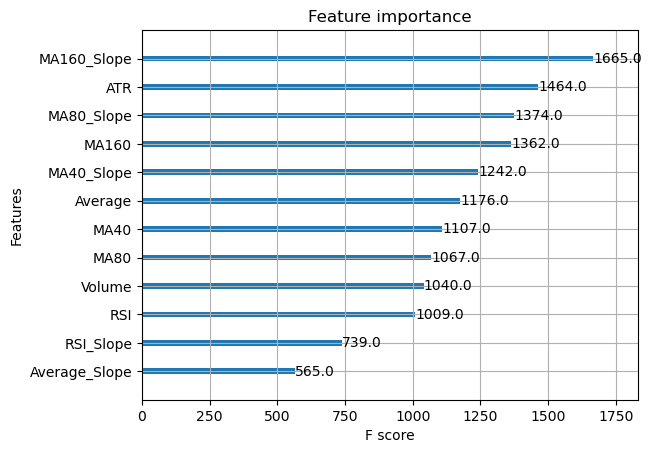

In [12]:
plot_importance(model)
pyplot.show()

**Save and Load Model**

In [13]:
#save model to disk
filename = 'model.sav'
joblib.dump(model, filename)

#load model from disk
loaded_model = joblib.load('model.sav')

**Backtesting**

In [14]:
df_model.tail()

,Open,High,Low,Close,Volume,ATR,RSI,Average,MA40,MA80,MA160,RSI_Slope,Average_Slope,MA40_Slope,MA80_Slope,MA160_Slope,Target
173442,1.09460,1.09488,1.09431,1.09462,1723.68,0.001188,51.952990,1.094595,1.093352,1.096221,1.101584,-0.660913,-7.621212e-05,-0.000016,-0.000139,-0.000047,0.0
173443,1.09461,1.09514,1.09443,1.09508,2747.83,0.001164,55.437382,1.094785,1.093347,1.096083,1.101544,-0.621559,-1.152121e-04,-0.000021,-0.000139,-0.000047,0.0
173444,1.09508,1.09558,1.09501,1.09515,7856.57,0.001134,55.960772,1.095295,1.093385,1.095943,1.101505,-0.234127,-5.803030e-05,-0.000021,-0.000139,-0.000047,0.0
173445,1.09515,1.09541,1.09466,1.09469,6276.75,0.001115,51.666331,1.095035,1.093433,1.095810,1.101461,-0.013783,1.336364e-05,-0.000015,-0.000139,-0.000046,0.0
173446,1.09468,1.09473,1.09391,1.09392,7221.37,0.001100,45.387526,1.094320,1.093482,1.095683,1.101415,-0.312894,9.696970e-07,-0.000006,-0.000137,-0.000046,0.0


In [20]:
class strat(Strategy):
    def init(self):
        #load the pretrained model
        self.model = joblib.load('model.sav')

        print(type(self.data))
        print(self.data)


    def next(self):
                
        data_dict = {
            'Open': self.data.Open,
            'Close': self.data.Close,
            'High': self.data.High,
            'Low': self.data.Low,
            'Volume': self.data.Volume,
            'ATR': self.data.ATR,
            'RSI': self.data.RSI,
            'Average': self.data.Average,
            'MA40': self.data.MA40,
            'MA80': self.data.MA80,
            'MA160': self.data.MA160,
            'RSI_Slope': self.data.RSI_Slope,
            'Average_Slope': self.data.Average_Slope,
            'MA40_Slope': self.data.MA40_Slope,
            'MA80_Slope': self.data.MA80_Slope,
            'MA160_Slope': self.data.MA160_Slope
        }

        d = pd.DataFrame(data_dict)

        #print(d.columns)
        # Assuming 'self.data' is a DataFrame with the necessary columns
        #features = tuple(['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'RSI_Slope', 'Average_Slope', 'MA40_Slope', 'MA80_Slope', 'MA160_Slope'])
        current_data = d.iloc[-1]

        #print(current_data.shape)


        prediction = self.model.predict(current_data)

        self.forecasts[-1] = prediction

        if prediction == 2 and not self.position.is_long:
            self.buy()
        elif prediction == 1 and not self.position.is_short:
            self.sell()


bt = Backtest(df_model, strat, cash = 10_000)
results = bt.run()
bt.plot()

/Users/retr0/anaconda3/lib/python3.11/site-packages/backtesting/backtesting.py:1054: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
/var/folders/cb/8365x3l96854c0l9xj35ljhm0000gn/T/ipykernel_36304/2392527619.py:51: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df_model, strat, cash = 10_000)


<class 'backtesting._util._Data'>
<Data i=123410 (173446) Open=1.09468, High=1.09473, Low=1.09391, Close=1.09392, Volume=7221.370000000003, ATR=0.0011003265324590376, RSI=45.38752564539918, Average=1.09432, MA40=1.0934822499999999, MA80=1.095683125, MA160=1.10141475, RSI_Slope=-0.3128944424498913, Average_Slope=9.696969697113966e-07, MA40_Slope=-5.624242424246704e-06, MA80_Slope=-0.00013687424242425167, MA160_Slope=-4.5533333333328576e-05, Target=0.0>


ValueError: feature_names mismatch: ['Volume', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'RSI_Slope', 'Average_Slope', 'MA40_Slope', 'MA80_Slope', 'MA160_Slope'] ['1']
expected Average_Slope, MA80_Slope, RSI_Slope, Volume, ATR, MA160, MA160_Slope, RSI, MA40_Slope, MA40, MA80, Average in input data
training data did not have the following fields: 1

**Trading Job Function**

In [ ]:
signal = 0

def trading_job():
    collector = CandleCollector(access_token, Pair.EURUSD)

SyntaxError: invalid syntax (93985540.py, line 4)